In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import metrics
from keras import optimizers
import numpy as np
import datetime
%load_ext tensorboard

c:\Program Files\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


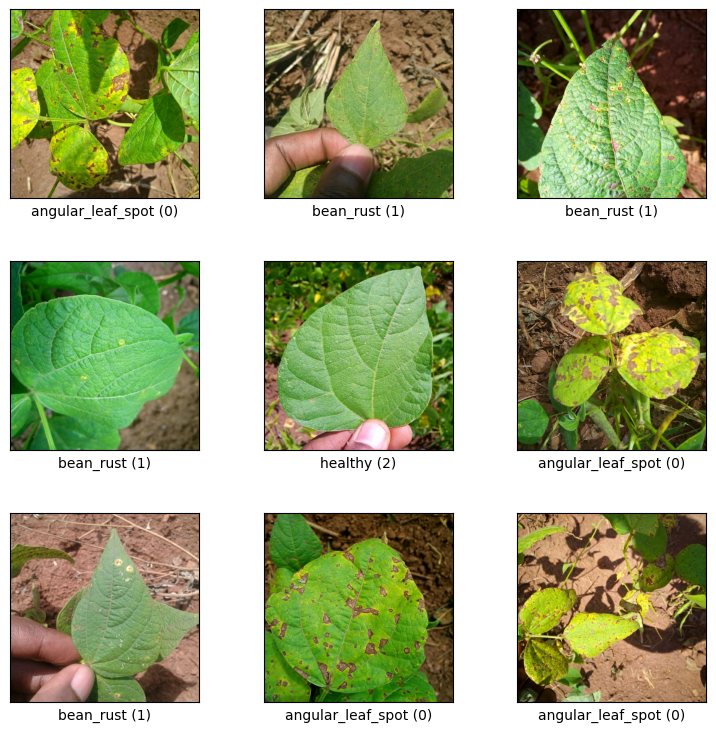

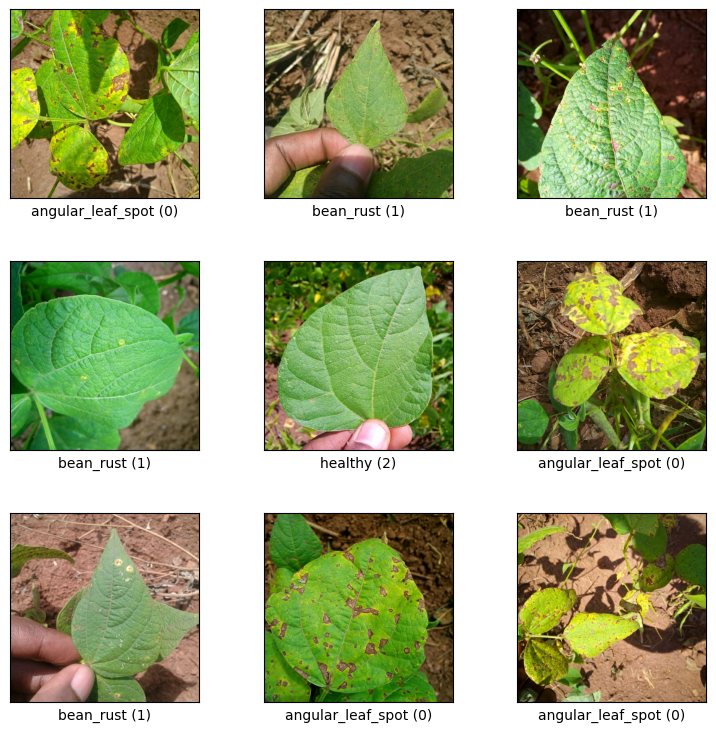

In [2]:
train, train_info = tfds.load(
    name='beans', split='train', shuffle_files=True, with_info=True)
valid, valid_info = tfds.load(
    name='beans', split='validation', shuffle_files=False, with_info=True)
test, test_info = tfds.load(
    name='beans', split='test', shuffle_files=False, with_info=True)
tfds.show_examples(test, test_info)


In [3]:
example_dict = next(iter(train))
print('Image shape', example_dict['image'].shape)
print('Label', example_dict['label'])


Image shape (500, 500, 3)
Label tf.Tensor(1, shape=(), dtype=int64)


In [ ]:
model = keras.Sequential(
    [
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(3),
    ]
)
model.build((None, 500, 500, 3))
model.summary()
model.compile(
    optimizer='adam', loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy']
)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 249, 249, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 247, 247, 32)      9248      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 123, 123, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 121, 121, 32)      9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 60, 60, 32)      

In [ ]:
def normalize_img(x):
    return (tf.cast(x['image'], tf.float32)/255.0) - 0.5, x['label']


In [ ]:
ds_train = train.map(normalize_img)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(train_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
ds_test = test.map(normalize_img)
ds_test = ds_test.cache()
ds_test = ds_test.shuffle(test_info.splits['test'].num_examples)
ds_test = ds_test.batch(128)
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
history = model.fit(ds_train, epochs=10, validation_data=ds_test)

Epoch 1/10
9/9 [==============================] - 51s 5s/step - loss: 1.9369 - accuracy: 0.3810 - val_loss: 1.0676 - val_accuracy: 0.3359
Epoch 2/10
9/9 [==============================] - 51s 6s/step - loss: 1.0154 - accuracy: 0.4613 - val_loss: 0.9064 - val_accuracy: 0.5859
Epoch 3/10


KeyboardInterrupt: 

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
